<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_hypo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if os.environ.get("CI_SMOKE"):
    NUM_WARMUP = 100
    NUM_SAMPLES = 100
else:
    NUM_WARMUP = 2000
    NUM_SAMPLES = 2000

# Hypothesis learning: toy data example

This notebook demonstrates how to apply the hypothesis learning to toy data. The [hypothesis learning](https://arxiv.org/abs/2112.06649) is based on the idea that in active learning, the correct model of the system’s behavior leads to a faster decrease in the overall Bayesian uncertainty about the system under study. In the hypothesis learning setup, the probabilistic models of the possible system’s behaviors (hypotheses) are wrapped into structured Gaussian processes, and a basic reinforcement learning policy (such as epsilon-greedy or softmax) is used to select a correct model from several competing hypotheses.

*Prepared by Maxim Ziatdinov (2023). Last updated in October 2023.*

## Install & Import

Install the latest GPax package from PyPI (this is best practice, as it installs the latest, deployed and tested version).

In [2]:
!pip install gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 11.7 MB/s eta 0:00:00


Import needed packages:

In [3]:
try:
    # For use on Google Colab
    import gpax

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

In [4]:
#@title Imports
from typing import Union, Dict, Type

import gpax

import jax.numpy as jnp
import numpy as onp
import numpyro
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

Enable some pretty plotting.

In [5]:
import matplotlib as mpl

In [6]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

# Hypothesis learning

In [7]:
#@title Plotting and data utilities { form-width: "20%" }

def update_datapoints(point_idx, point_measured, X_measured, y_measured, X_unmeasured):
    """Updates "measured" and "unmeasured" arrays of (dummy) data points"""
    X_measured = jnp.append(X_measured, X_unmeasured[point_idx][None], 0)
    X_unmeasured = jnp.delete(X_unmeasured, point_idx, 0)
    y_measured = jnp.append(y_measured, point_measured)
    return X_measured, y_measured, X_unmeasured


def plot_results(X_measured, y_measured, X_unmeasured, y_pred, y_sampled, obj, model_idx, rewards, **kwargs):
    X = jnp.concatenate([X_measured, X_unmeasured], axis=0).sort()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X_measured, y_measured, marker='x', s=100, c='k', label="Measured points", zorder=1)
    ax1.plot(X, y_pred, c='red', label='Model reconstruction', zorder=0)
    ax1.fill_between(X, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                     color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    ax1.set_xlabel("$x$", fontsize=18)
    ax1.set_ylabel("$y$", fontsize=18)
    ax2.plot(X_unmeasured, obj, c='k')
    ax2.vlines(X_unmeasured[obj.argmax()], obj.min(), obj.max(), linestyles='dashed', label= "Next point")
    ax2.set_xlabel("$x$", fontsize=18)
    ax2.set_ylabel("Acquisition function", fontsize=18)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper left")
    step = kwargs.get("e", 0)
    plt.suptitle("Step: {},  Sampled Model: {}, Rewards: {}".format(
        step+1, model_idx, onp.around(rewards, 3).tolist()), fontsize=24)
    # fig.savefig("./{}.png".format(step))
    plt.show()


def plot_acq(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.vlines(x[idx], obj.min(), obj.max(), linestyles='dashed')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()


def plot_final_result(X, y, X_unmeasured, y_pred, y_sampled, seed_points):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
                cmap='viridis', label="Sampled points", zorder=2)
    cbar = plt.colorbar(label="Exploration step")
    cbar_ticks = jnp.arange(2, len(X[seed_points:]) + 1, 2)
    cbar.set_ticks(cbar_ticks)
    plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
                c='k', label="Seed points", zorder=1)
    plt.plot(X_unmeasured, y_pred, '--', c='red', label='Model reconstruction', zorder=1)
    plt.plot(X_unmeasured, truefunc, c='k', label="Ground truth", zorder=0)
    plt.fill_between(X_unmeasured, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                            color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    plt.xlabel("$x$", fontsize=12)
    plt.ylabel("$y$", fontsize=12)
    plt.legend(fontsize=9, loc='upper left')
    #plt.ylim(1.8, 6.6)
    plt.show()

First, let's generate some data. As a practical example chosen here, we are interested in the active learning of phase
diagram that has a transition between different phases. The phase transition manifests in discontinuity of a measurable system’s property, such as heat capacity. However, we usually do not know where a phase transition occurs precisely, nor are we aware of the exact behavior of the property of interest in different phases. We note that using a standard Gaussian process-based active learning is not an optimal choice in such a case as simple GP struggles around the discontinuity point.

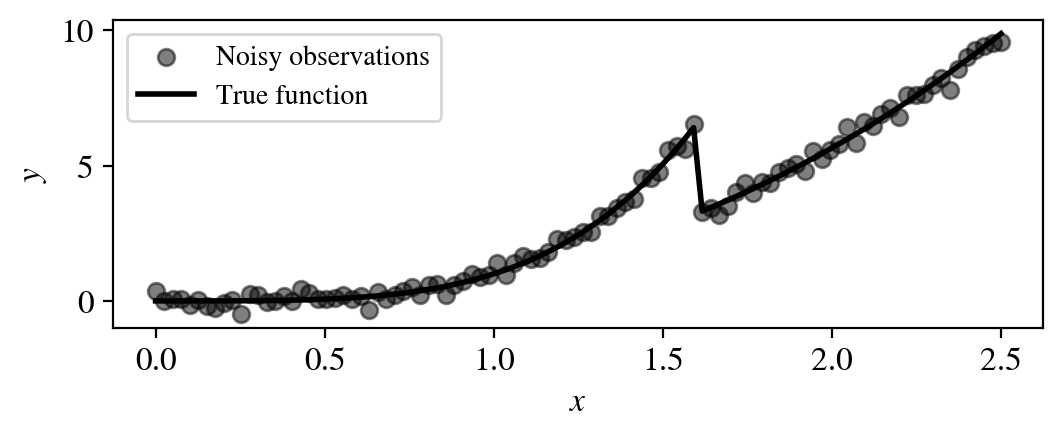

In [8]:
def function_(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return jnp.piecewise(
        x,
        [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]]
    )


X = jnp.linspace(0.0, 2.5, 100)
params_i = {"t": 1.6, "beta1": 4, "beta2": 2.5}

truefunc = function_(X, params_i)
Y = truefunc + 0.2 * onp.random.normal(size=len(X))

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.scatter(X, Y, alpha=0.5, c='k', label="Noisy observations")
ax.plot(X, truefunc, lw=2, c='k', label="True function")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.show()

Of course, our algorithm is not going to see all these observations. Nor it is going to see the true function. Instead, we are going to start with just 4 measured points.

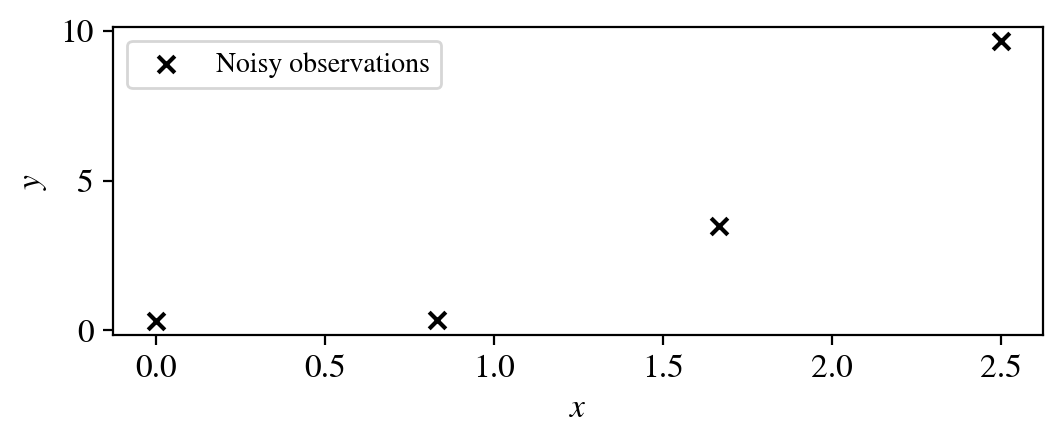

In [9]:
onp.random.seed(1)

seed_idx = onp.array([0, 33, 66, 99])
X_measured = X[seed_idx]
X_unmeasured = onp.delete(X, seed_idx)
y_measured = function_(X_measured, params_i) + 0.2 * onp.random.normal(size=len(X_measured))
num_seed_points = len(X_measured)

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.scatter(X_measured, y_measured, alpha=1.0, c='k', marker='x', label="Noisy observations")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.show()

Next, we define possible models of system's behavior as dereministic functions:

In [10]:
def piecewise1(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    """Power law behavior before the transition and linear behavior after the transition"""
    return jnp.piecewise(
        x,
        [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta"], lambda x: params["c"]*x]
    )

def piecewise2(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    """Linear behavior before and after the transition"""
    return jnp.piecewise(
        x,
        [x < params["t"], x >= params["t"]],
        [lambda x: params["b"]*x, lambda x: params["c"]*x]
    )

def piecewise3(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    """Power-law behavior before and after the transition"""
    return jnp.piecewise(
        x,
        [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]]
    )

We put priors over parameters of each model to make them probabilistic:

In [11]:
def piecewise1_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta = numpyro.sample("beta", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta": beta, "c": c}

def piecewise2_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    b = numpyro.sample("b", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "b": b, "c": c}

def piecewise3_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta1 = numpyro.sample("beta1", numpyro.distributions.Normal(3, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}

Let's also specify custom priors over GP kernel (this step is optional):

In [12]:
def gp_kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

Define a simple reward function for hypothesis learning:

In [13]:
def get_reward(obj_history):
    """A reward of +/-1 is given if the median uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    r = 1 if obj_history[-1] < obj_history[-2] else -1
    return r

The main part (Algorithm 1 in the paper):

Warmup step 1/3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:29<00:00, 135.00it/s, 1023 steps of size 6.83e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.72      0.73      2.68      1.41      3.88     64.99      1.00
         c      3.55      0.48      3.58      2.79      4.31     50.02      1.03
  k_length      0.46      0.29      0.43      0.00      0.88     59.74      1.00
   k_scale      1.07      1.20      0.73      0.06      2.29     76.17      1.01
     noise      1.13      1.01      0.87      0.05      2.35     74.51      1.00
         t      1.59      0.38      1.72      0.95      2.00     46.60      1.01



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:11<00:00, 336.62it/s, 127 steps of size 4.35e-02. acc. prob=0.77] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.48      0.90      2.40      1.02      3.85    604.17      1.00
         c      3.41      0.56      3.41      2.50      4.31    517.04      1.00
  k_length      0.47      0.28      0.47      0.00      0.88   1011.29      1.00
   k_scale      1.42      1.41      0.98      0.06      3.05   1107.55      1.00
     noise      1.44      1.46      1.01      0.05      3.08    729.12      1.00
         t      1.40      0.46      1.52      0.71      2.00    495.93      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 623.12it/s, 15 steps of size 3.50e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.93      0.96      2.90      1.36      4.51   1071.69      1.00
     beta2      2.46      0.14      2.47      2.24      2.69   1043.29      1.00
  k_length      0.51      0.29      0.50      0.08      0.98   1687.71      1.00
   k_scale      0.75      0.80      0.50      0.03      1.60   1272.77      1.00
     noise      0.73      0.75      0.50      0.04      1.49   1223.42      1.00
         t      1.16      0.40      1.15      0.50      1.66   1319.79      1.00

Warmup step 2/3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:30<00:00, 132.79it/s, 1023 steps of size 2.06e-03. acc. prob=0.81]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.66      0.77      2.61      1.31      3.80    336.75      1.00
         c      3.63      0.44      3.67      2.94      4.33    149.73      1.03
  k_length      0.50      0.28      0.50      0.11      0.99    409.59      1.00
   k_scale      1.07      1.13      0.72      0.06      2.28    379.09      1.00
     noise      0.84      0.88      0.57      0.03      1.91    280.79      1.00
         t      1.61      0.37      1.74      0.98      2.00    158.23      1.01



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:24<00:00, 162.91it/s, 1023 steps of size 5.36e-03. acc. prob=0.75]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.40      0.82      2.34      1.04      3.71    616.23      1.00
         c      3.55      0.50      3.57      2.76      4.37    664.91      1.00
  k_length      0.51      0.27      0.50      0.13      0.98   1006.38      1.00
   k_scale      1.52      1.47      1.09      0.07      3.30    727.46      1.00
     noise      1.03      1.10      0.70      0.06      2.24    833.22      1.00
         t      1.49      0.43      1.69      0.80      2.00    435.91      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 495.80it/s, 15 steps of size 1.83e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.98      0.99      2.95      1.39      4.62    973.92      1.00
     beta2      2.49      0.11      2.49      2.30      2.66    822.29      1.00
  k_length      0.53      0.29      0.54      0.10      0.98   1563.61      1.00
   k_scale      0.70      0.70      0.49      0.05      1.46   1210.35      1.00
     noise      0.57      0.56      0.40      0.03      1.23   1157.51      1.00
         t      1.15      0.39      1.14      0.50      1.65   1187.44      1.00

Warmup step 3/3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:16<00:00, 242.93it/s, 255 steps of size 1.08e-02. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      3.01      0.89      3.03      1.54      4.49    930.73      1.00
         c      3.54      0.44      3.53      2.83      4.24    827.50      1.00
  k_length      0.44      0.30      0.41      0.00      0.86   1113.70      1.00
   k_scale      1.09      1.10      0.76      0.08      2.28    980.98      1.00
     noise      1.64      1.14      1.36      0.32      3.08   1255.53      1.00
         t      1.31      0.37      1.30      0.83      1.98    782.28      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:21<00:00, 184.08it/s, 1023 steps of size 2.39e-03. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.63      0.90      2.67      1.05      4.03    659.58      1.00
         c      3.55      0.48      3.55      2.76      4.31    544.44      1.01
  k_length      0.46      0.30      0.46      0.00      0.88    647.69      1.00
   k_scale      1.32      1.29      0.92      0.07      2.77    836.37      1.00
     noise      1.86      1.32      1.54      0.25      3.47    935.62      1.00
         t      1.29      0.41      1.29      0.72      2.00    727.80      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:32<00:00, 124.18it/s, 1023 steps of size 1.31e-04. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.92      0.18      3.90      3.61      4.21     19.37      1.00
     beta2      2.50      0.09      2.50      2.36      2.64      4.91      1.35
  k_length      0.56      0.25      0.62      0.22      0.93      6.27      1.03
   k_scale      0.51      0.29      0.47      0.07      0.84      8.08      1.32
     noise      0.35      0.19      0.32      0.07      0.63      4.06      1.74
         t      1.63      0.02      1.63      1.59      1.66    257.07      1.00

Exploration step 4/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:38<00:00, 104.39it/s, 1023 steps of size 6.84e-05. acc. prob=0.88]
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:40<

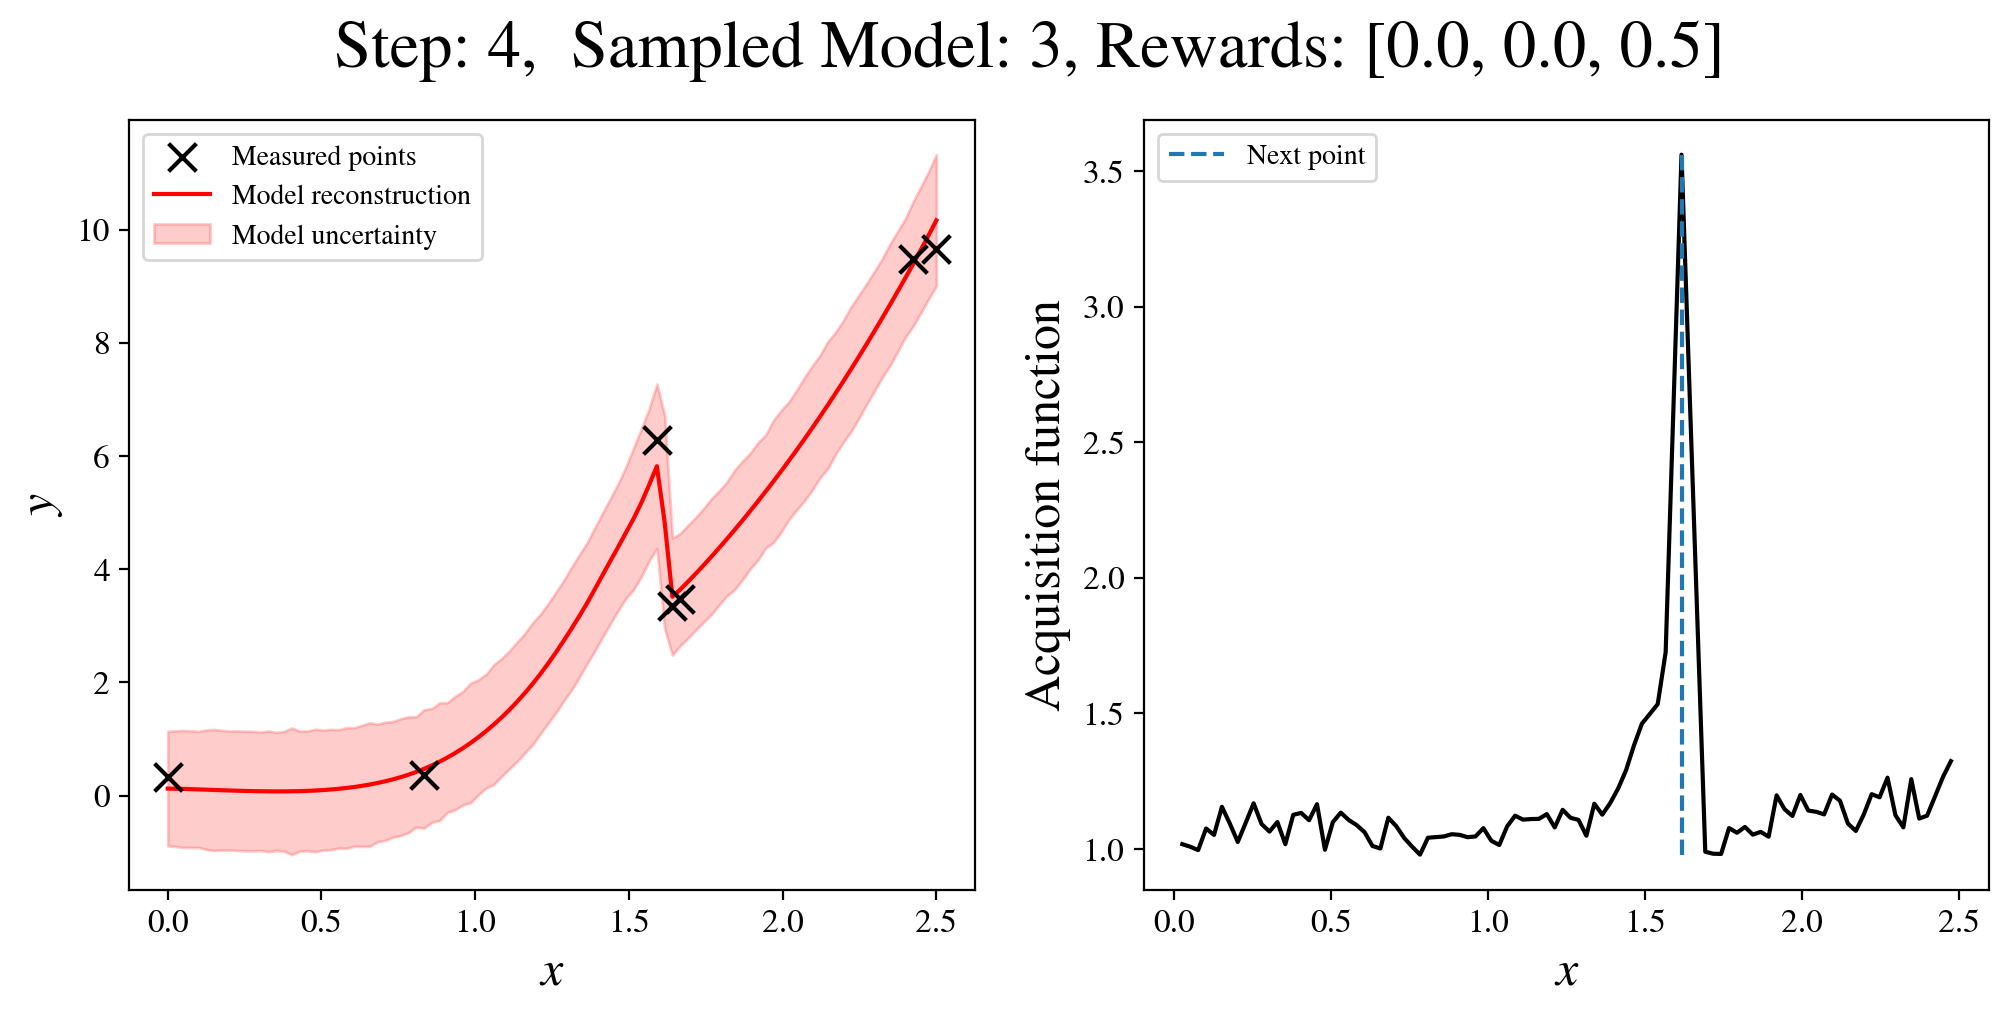

Exploration step 5/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:38<00:00, 103.06it/s, 1023 steps of size 1.85e-03. acc. prob=0.73]


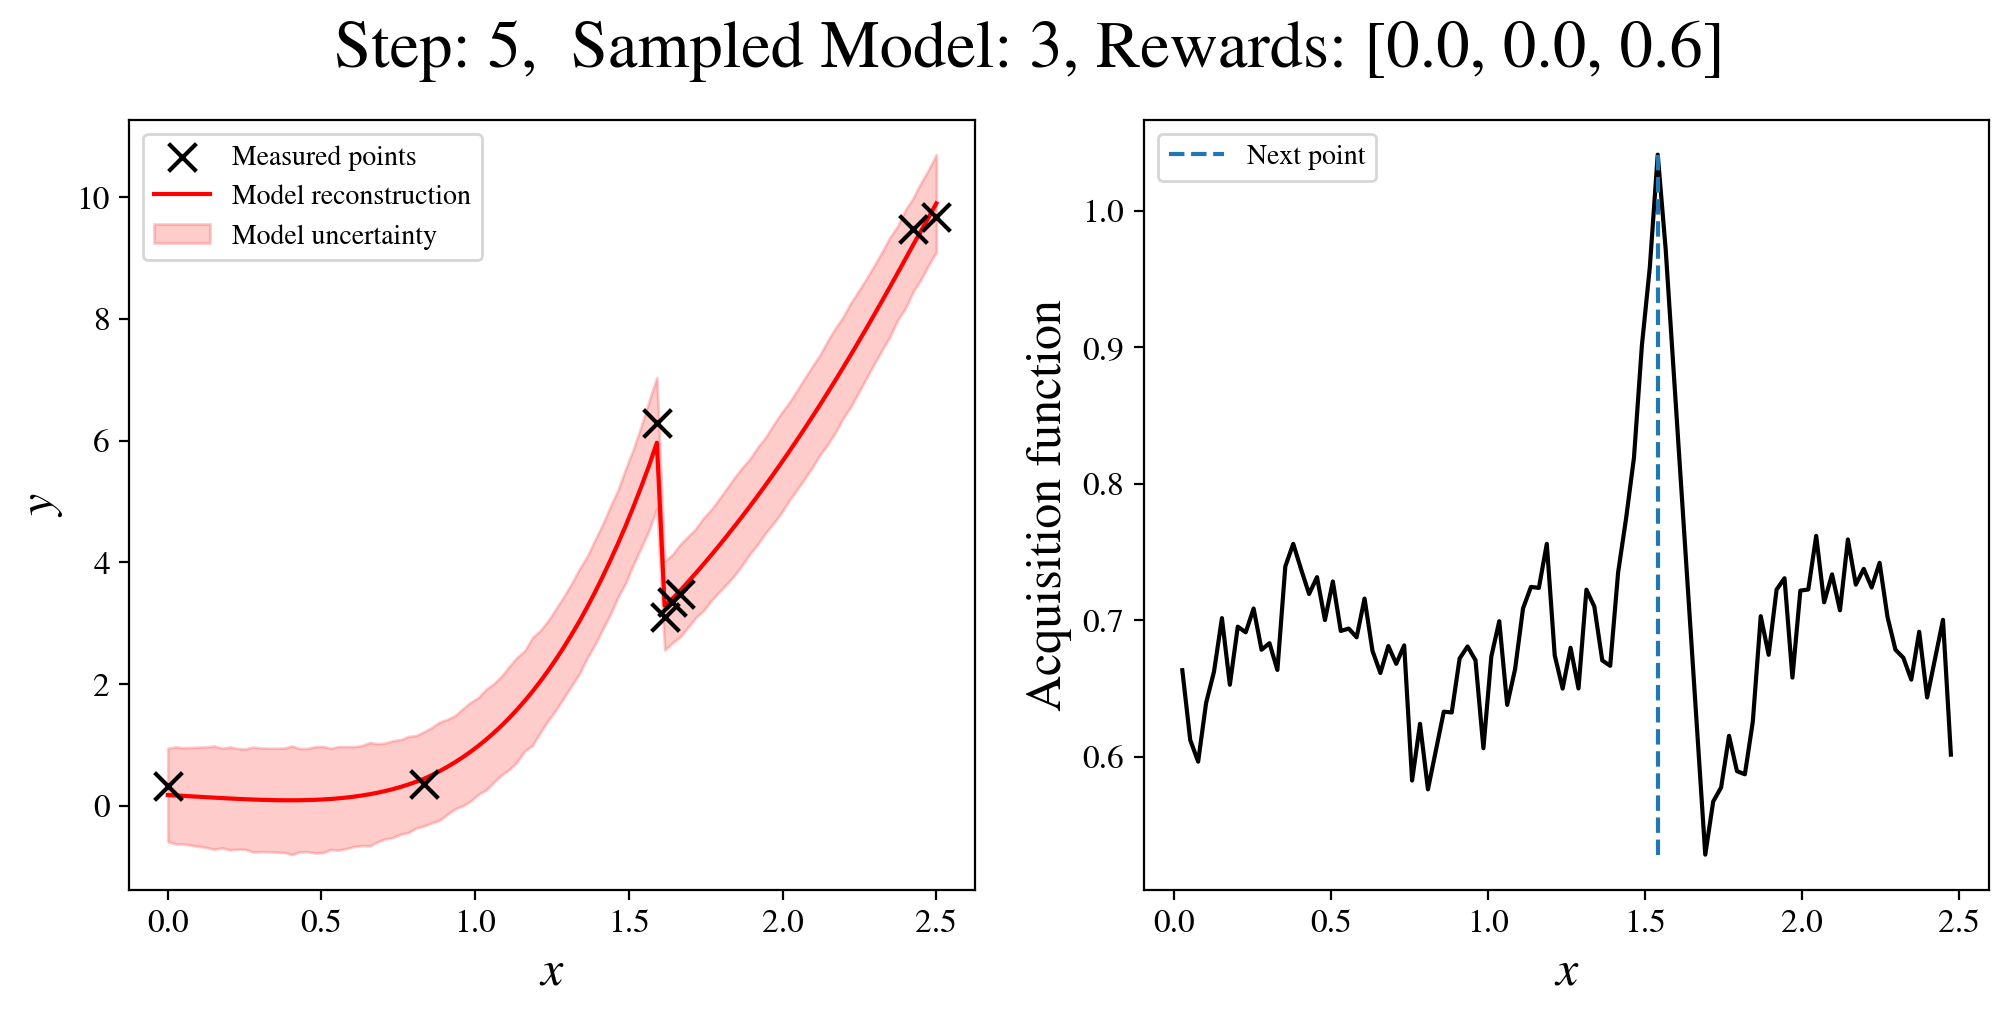

Exploration step 6/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:51<00:00, 77.89it/s, 1023 steps of size 7.11e-04. acc. prob=0.90]
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:51<0

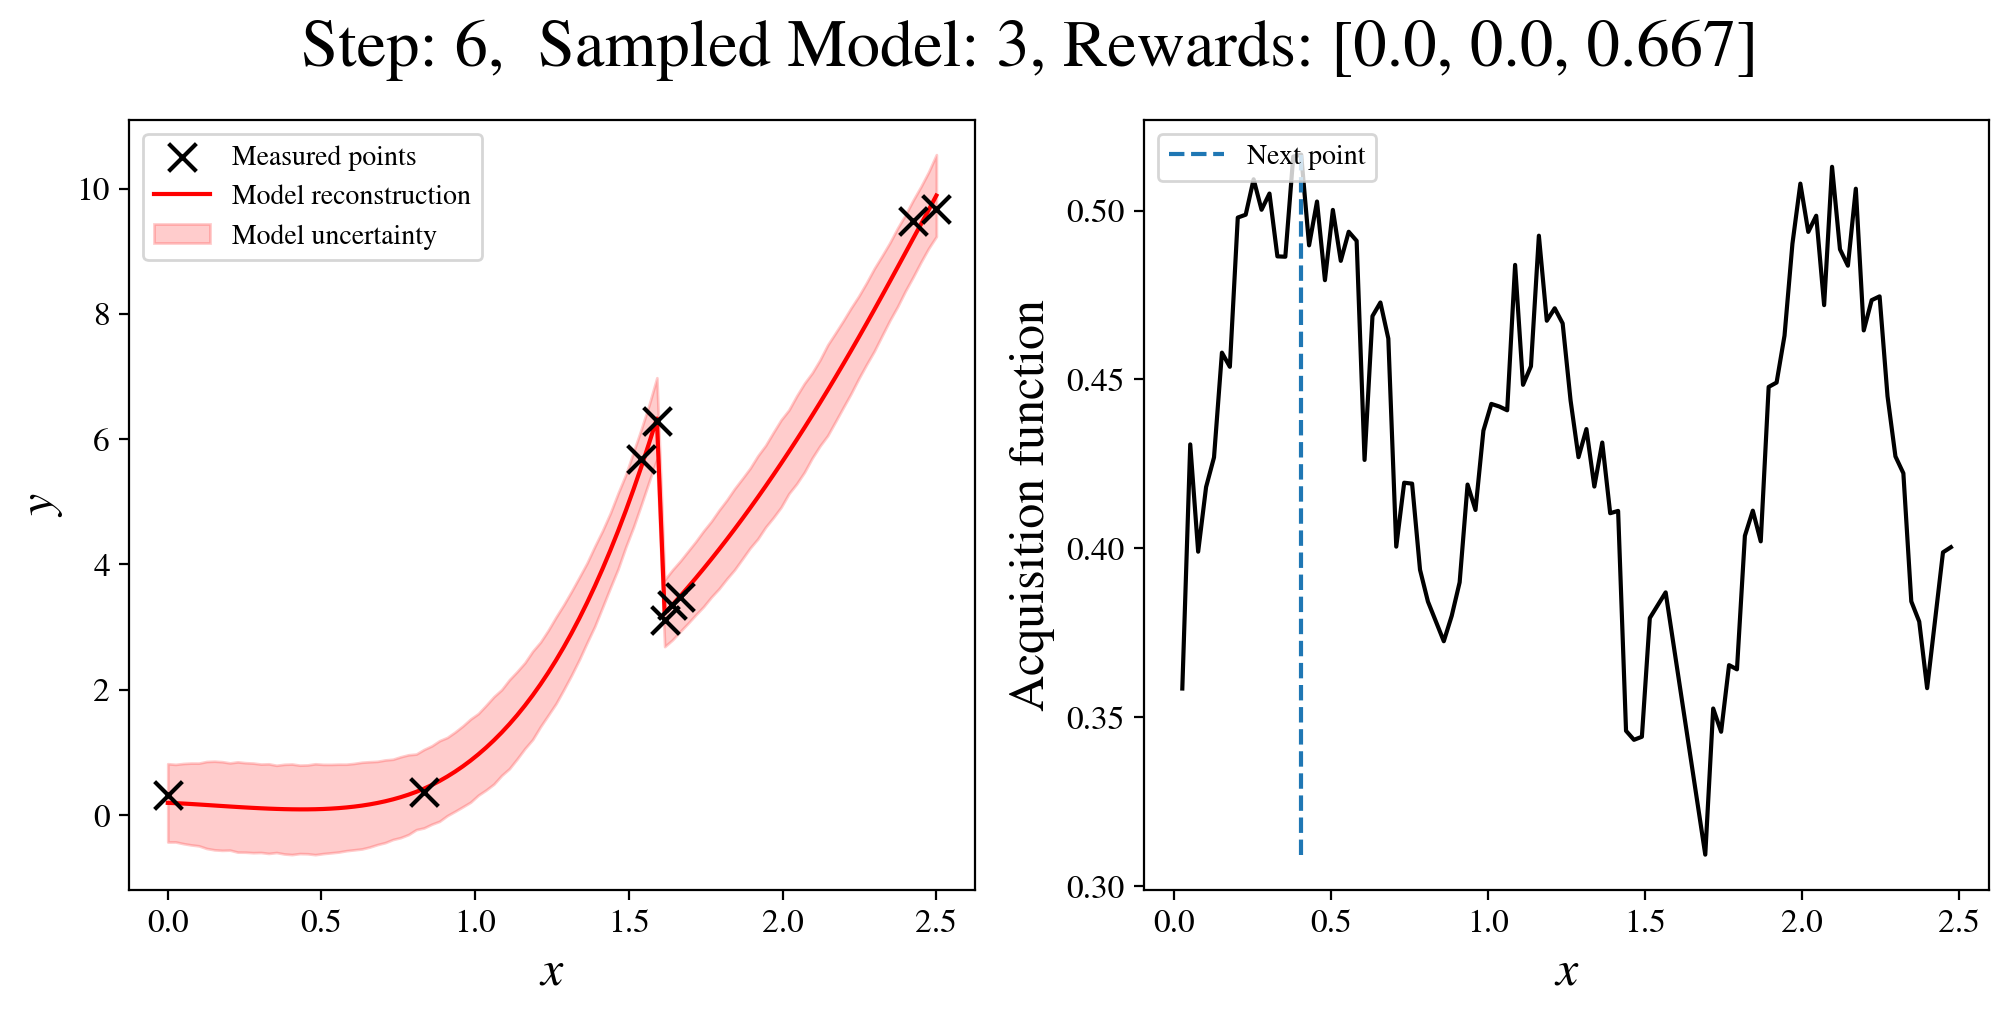

Exploration step 7/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:59<00:00, 66.74it/s, 1023 steps of size 3.16e-03. acc. prob=0.74]


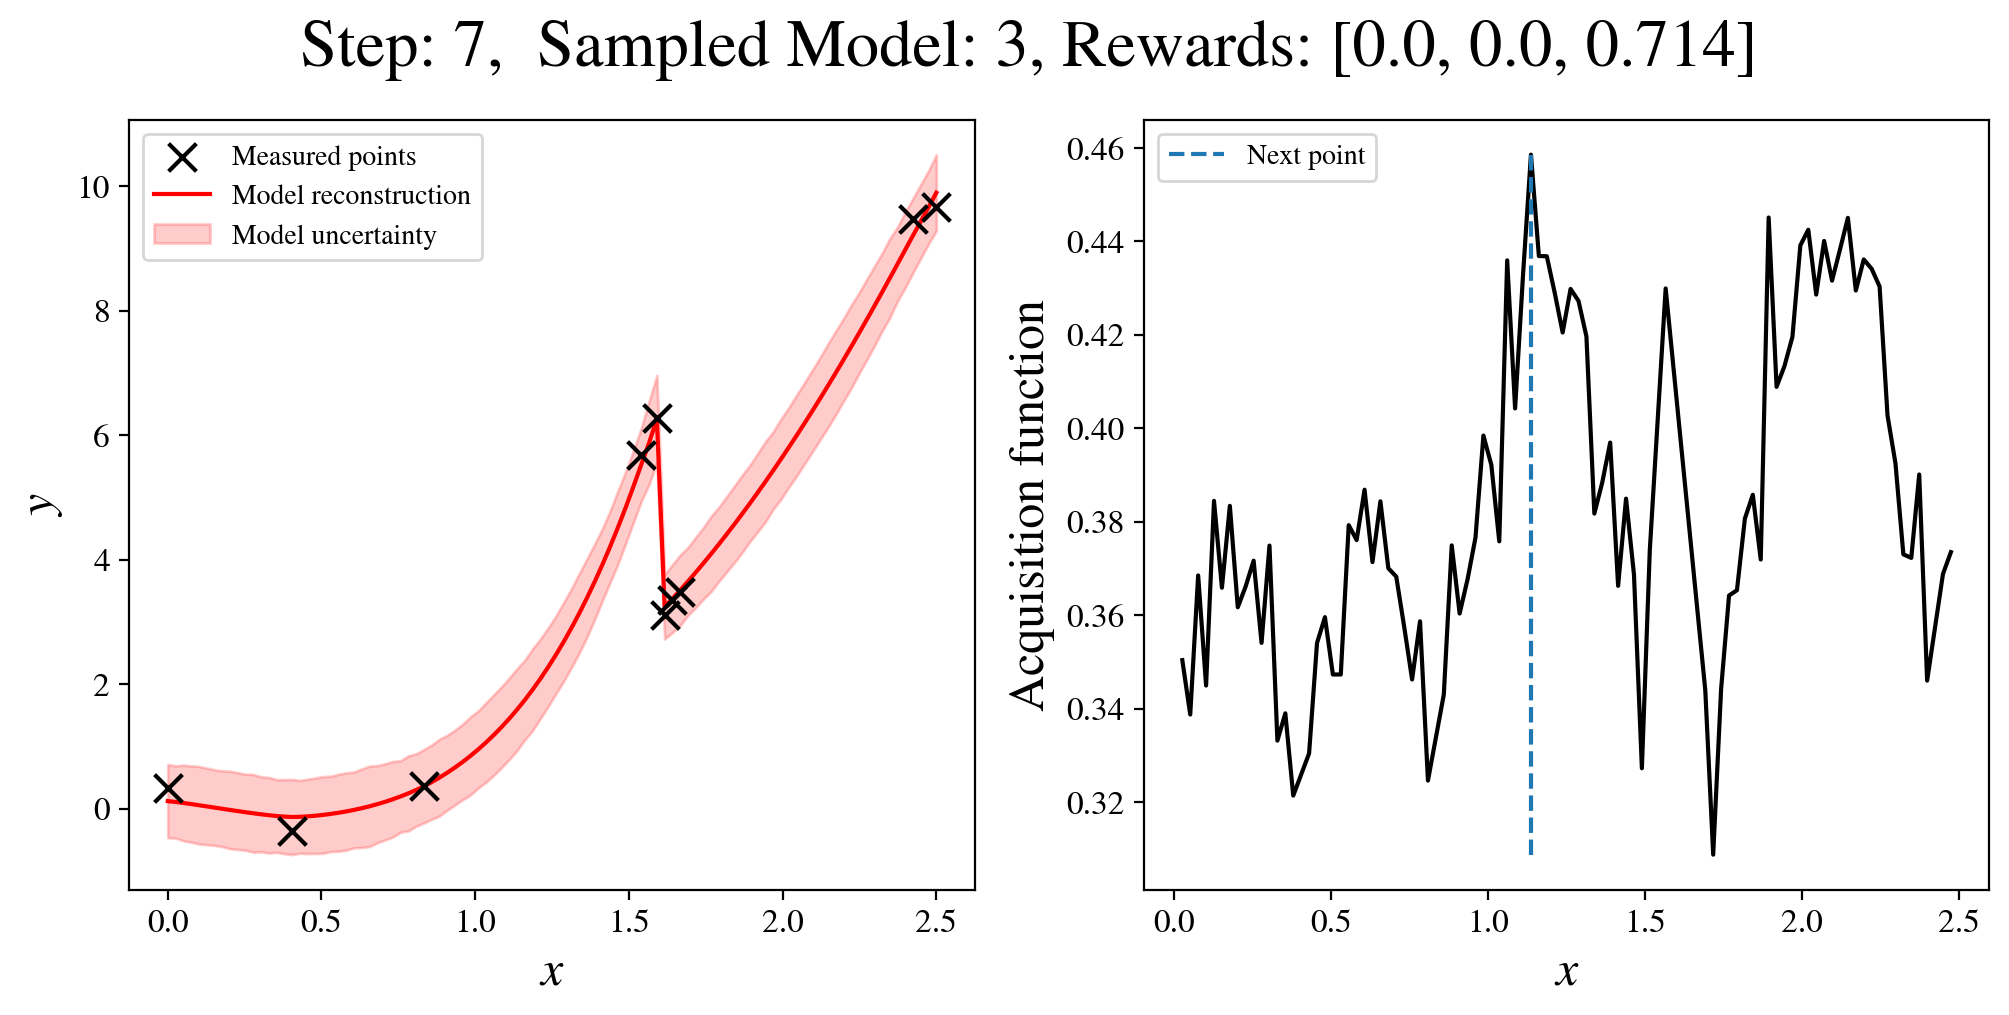

Exploration step 8/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:09<00:00, 57.56it/s, 1023 steps of size 9.52e-04. acc. prob=0.81]


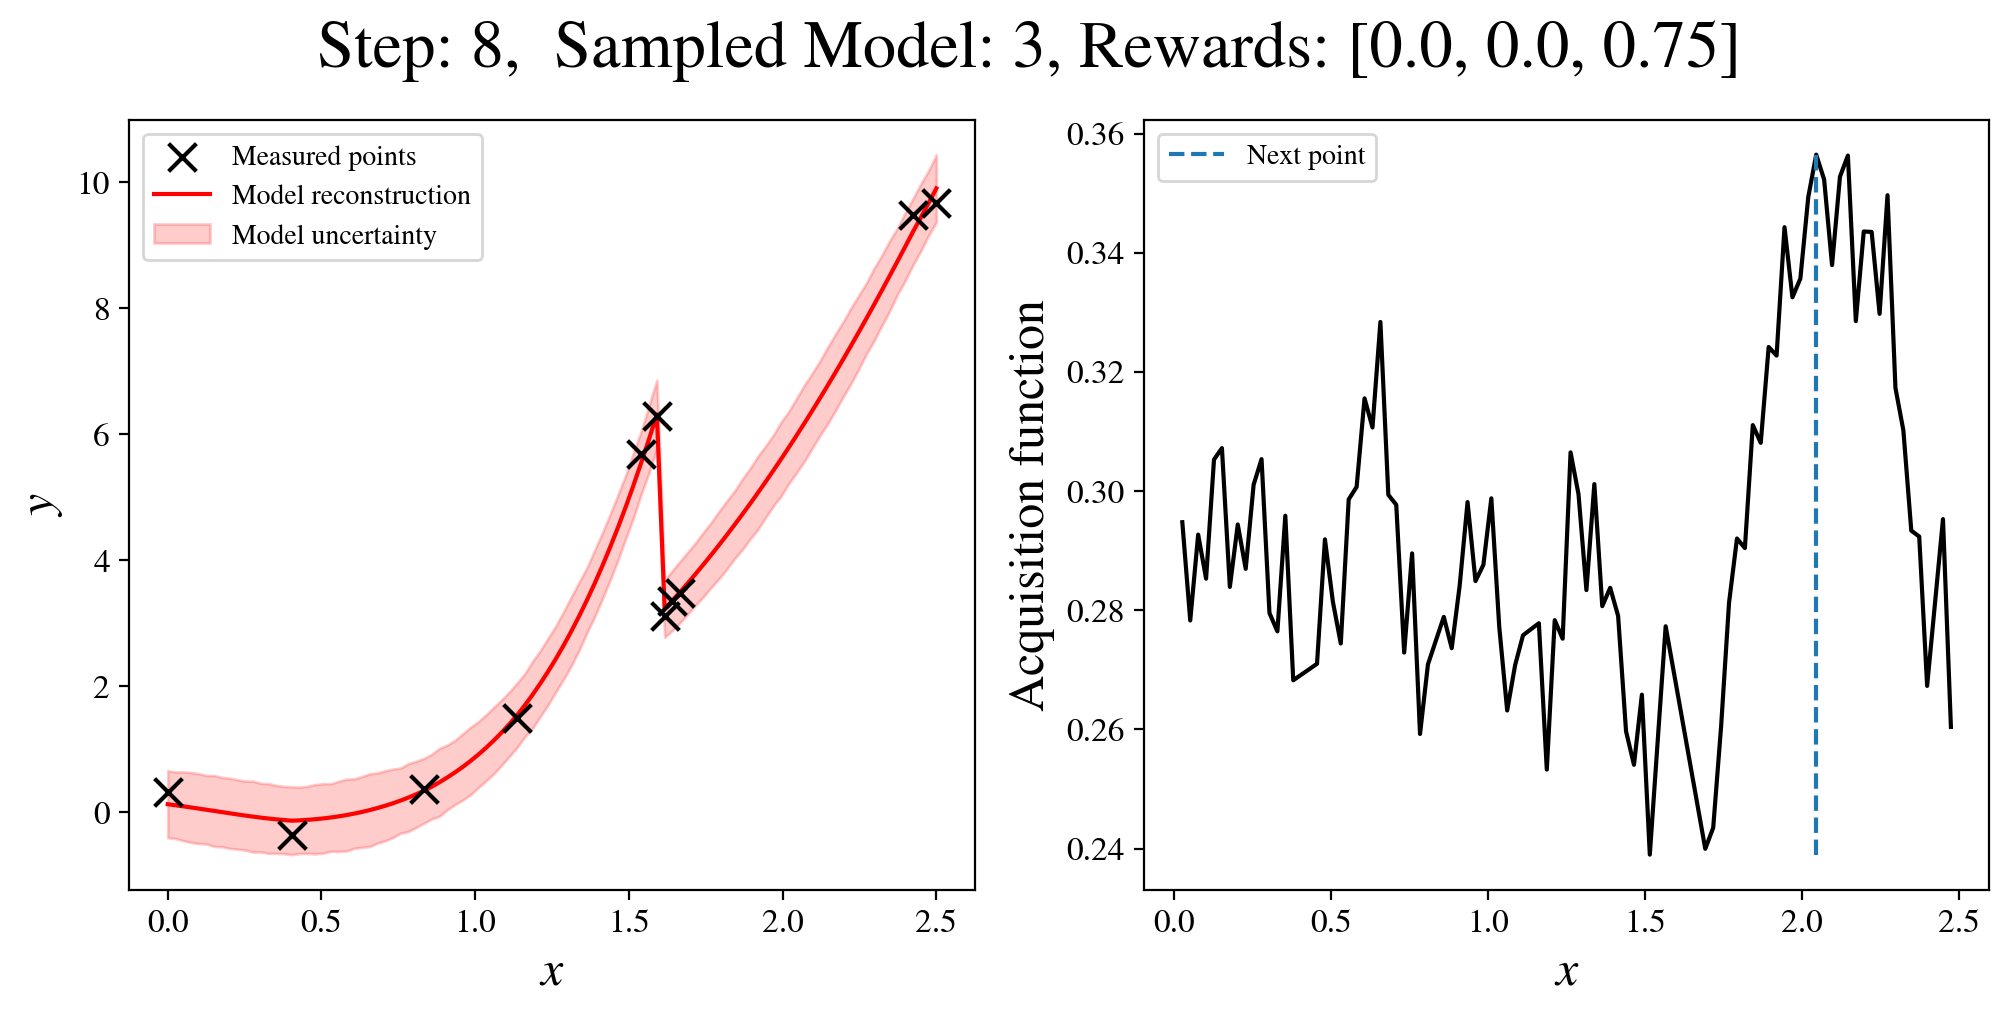

Exploration step 9/15
Using model 1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:01<00:00, 64.95it/s, 1023 steps of size 2.77e-03. acc. prob=0.80]


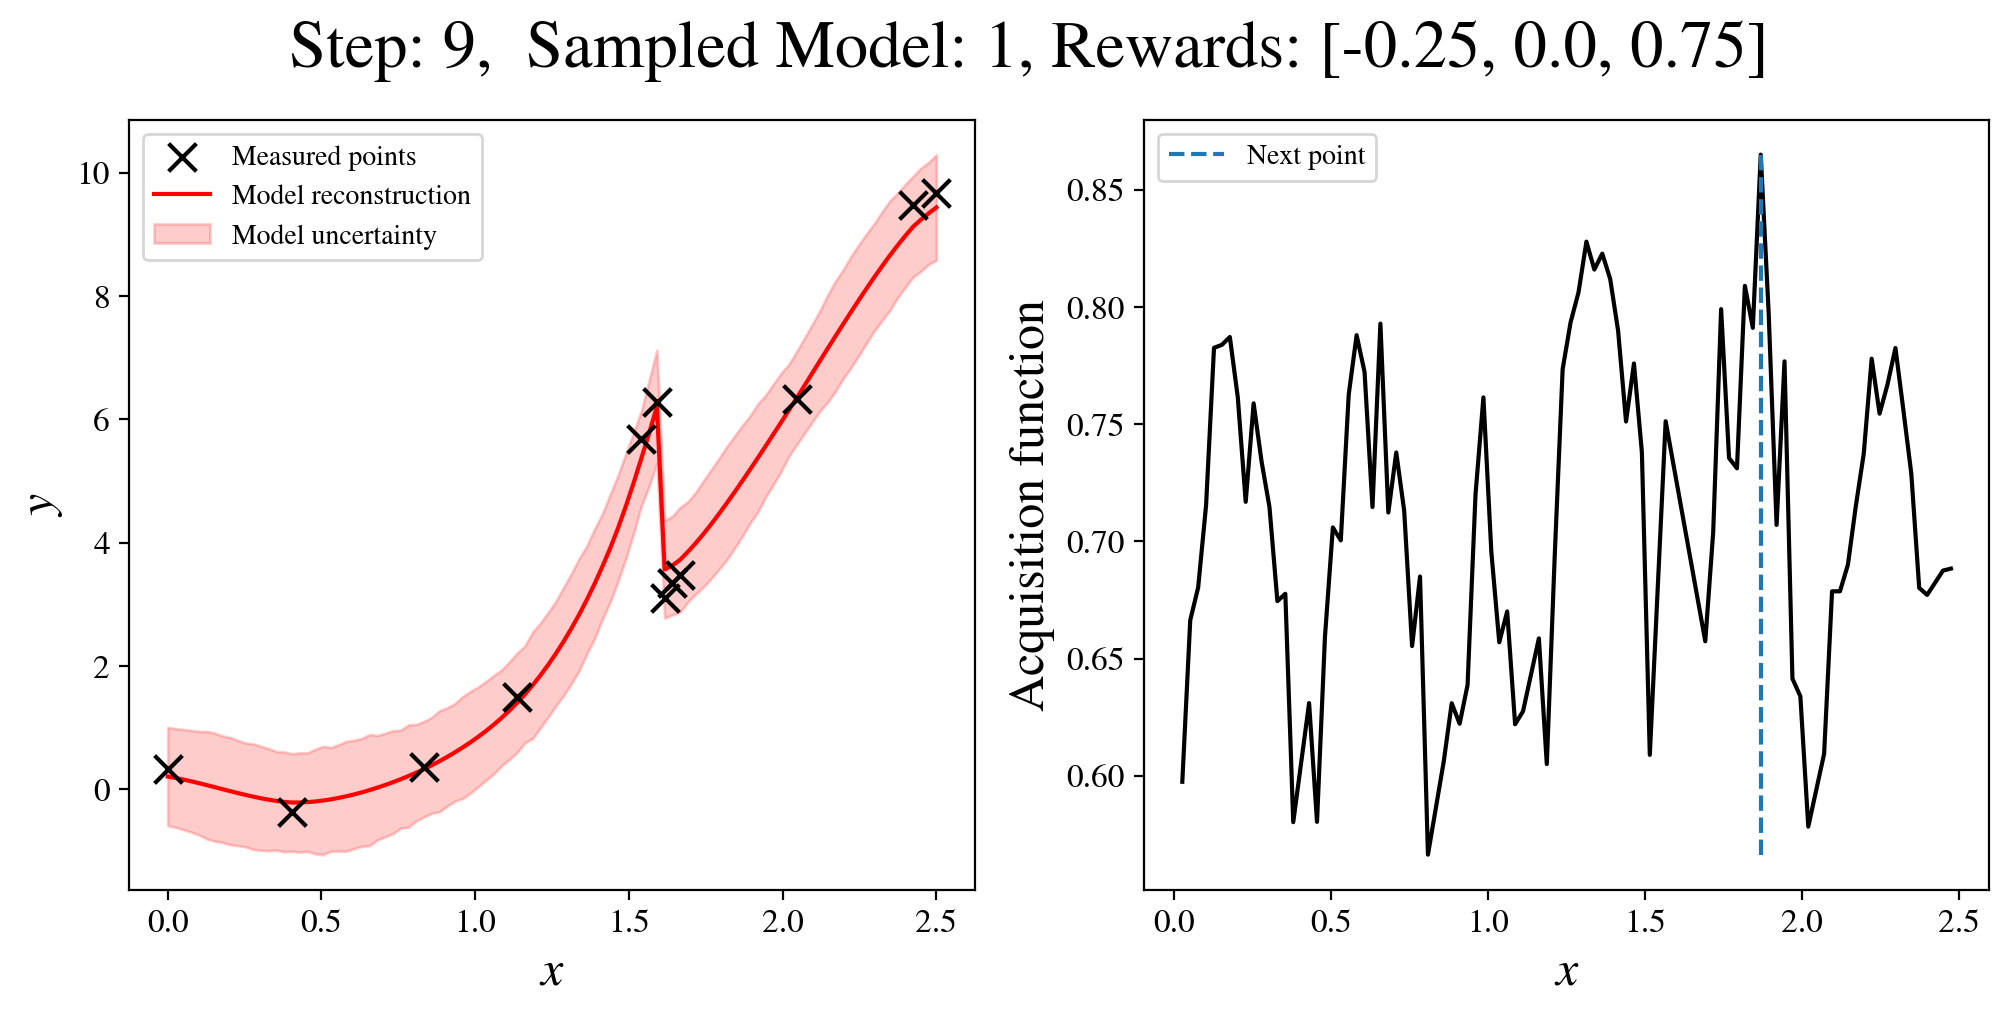

Exploration step 10/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:18<00:00, 50.92it/s, 1023 steps of size 4.55e-03. acc. prob=0.73]


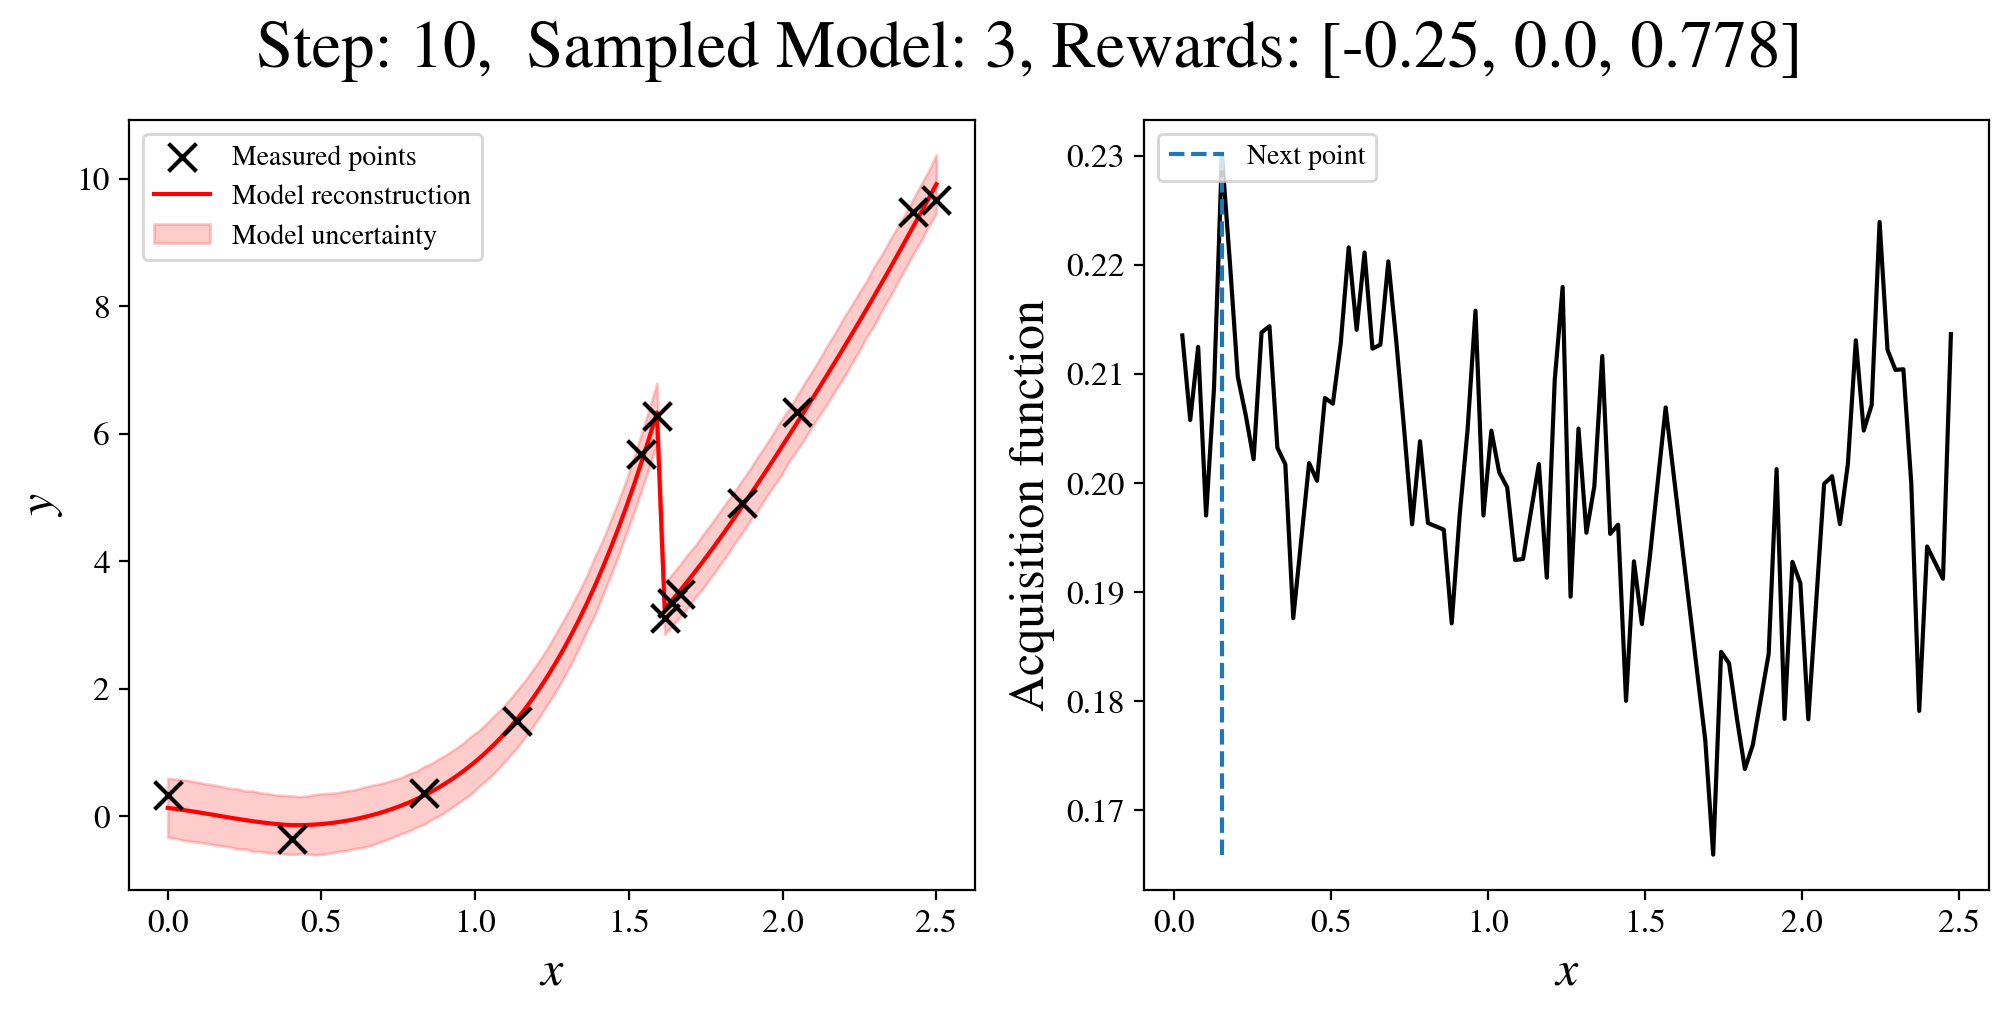

Exploration step 11/15
Using model 2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:32<00:00, 43.27it/s, 1023 steps of size 6.08e-05. acc. prob=0.84]
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:29<0

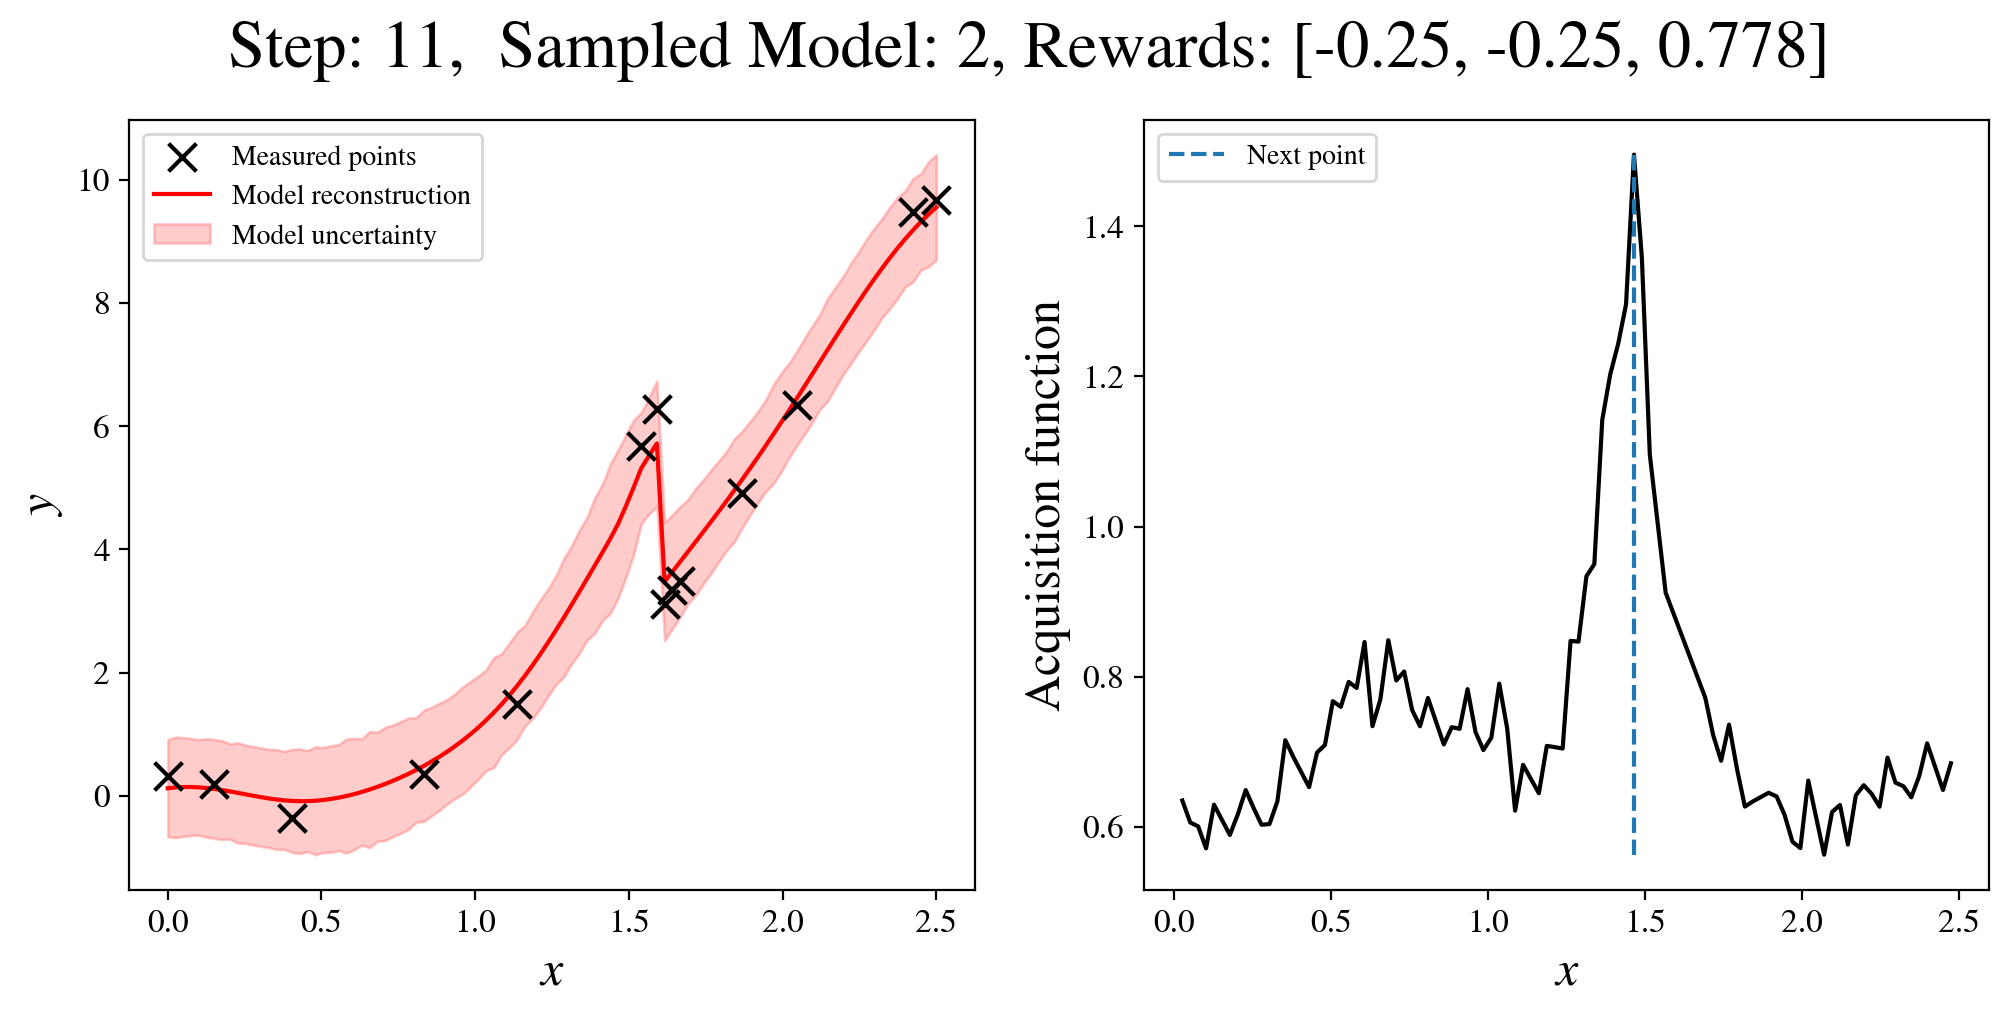

Exploration step 12/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:44<00:00, 38.41it/s, 1023 steps of size 3.06e-03. acc. prob=0.76]


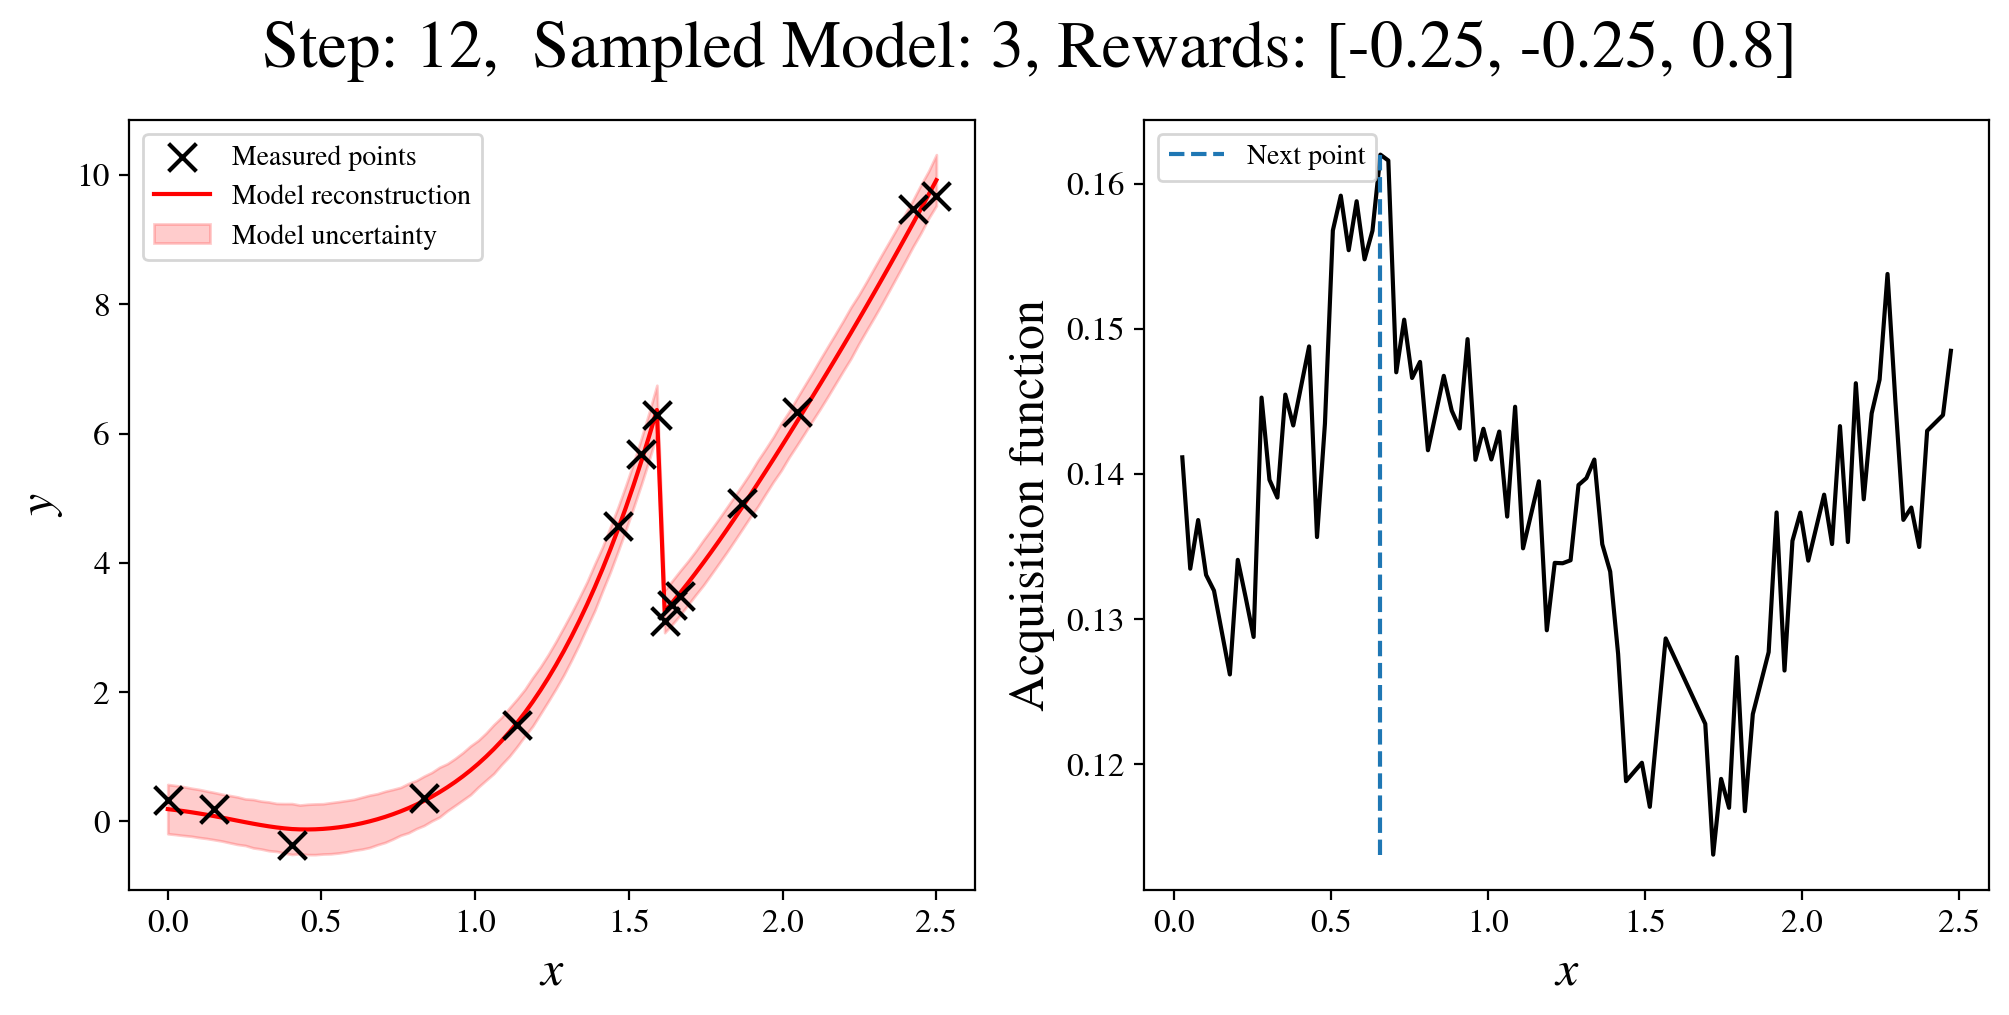

Exploration step 13/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:28<00:00, 45.02it/s, 1023 steps of size 3.13e-03. acc. prob=0.77]


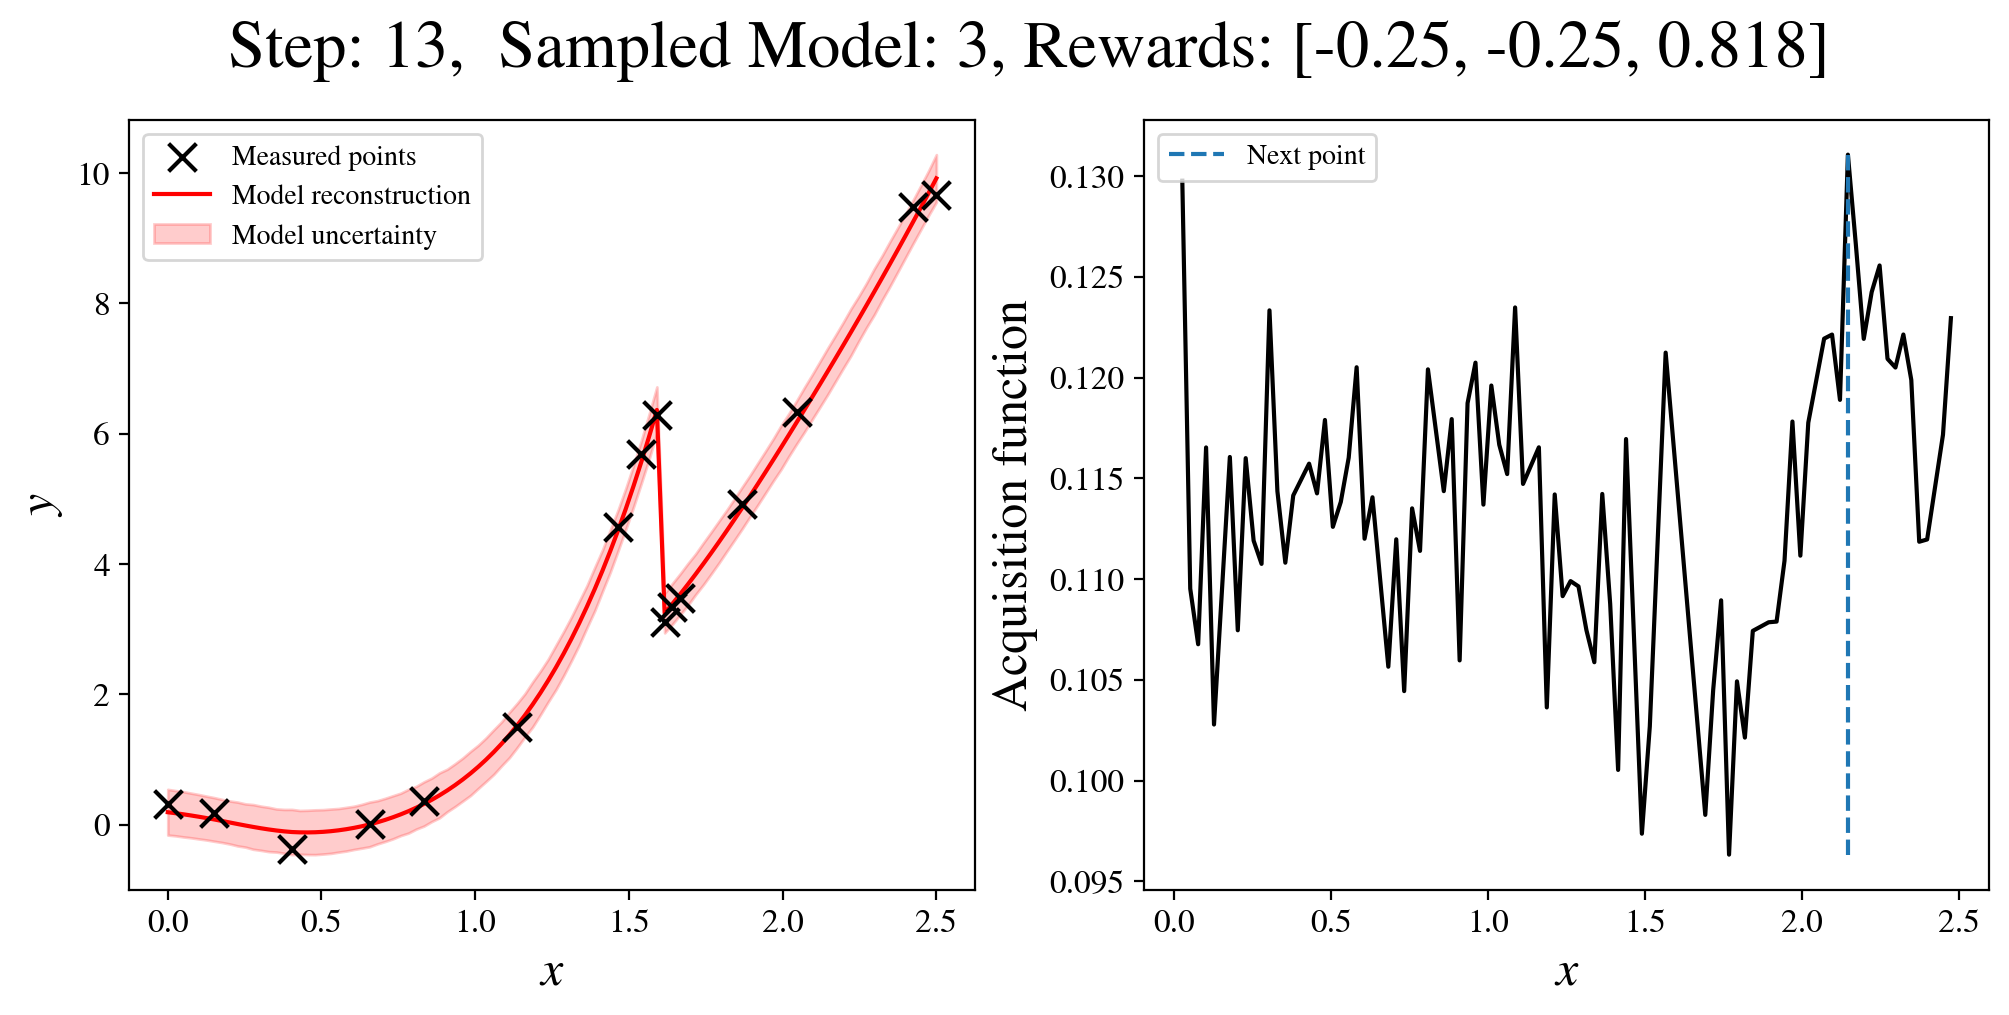

Exploration step 14/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:50<00:00, 36.22it/s, 1023 steps of size 2.41e-03. acc. prob=0.80]


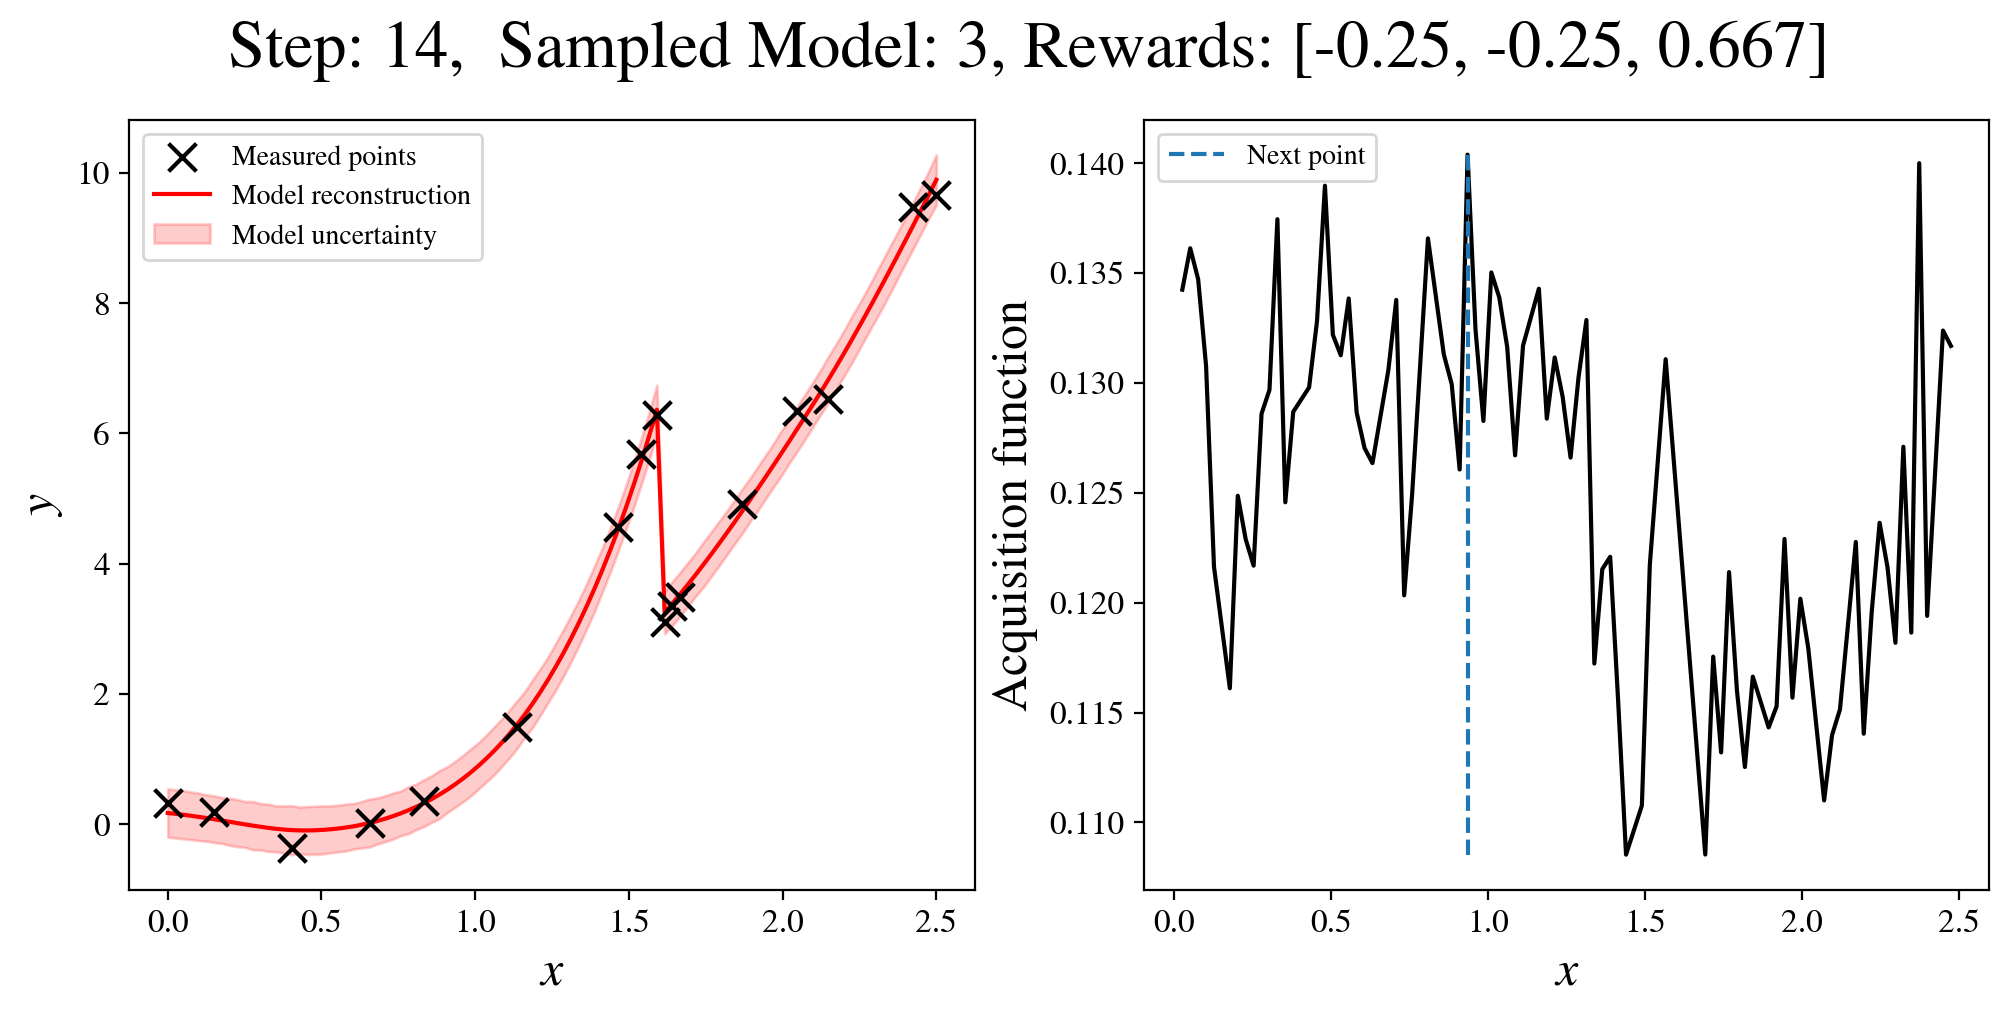

Exploration step 15/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [02:00<00:00, 33.06it/s, 1023 steps of size 2.68e-03. acc. prob=0.78]


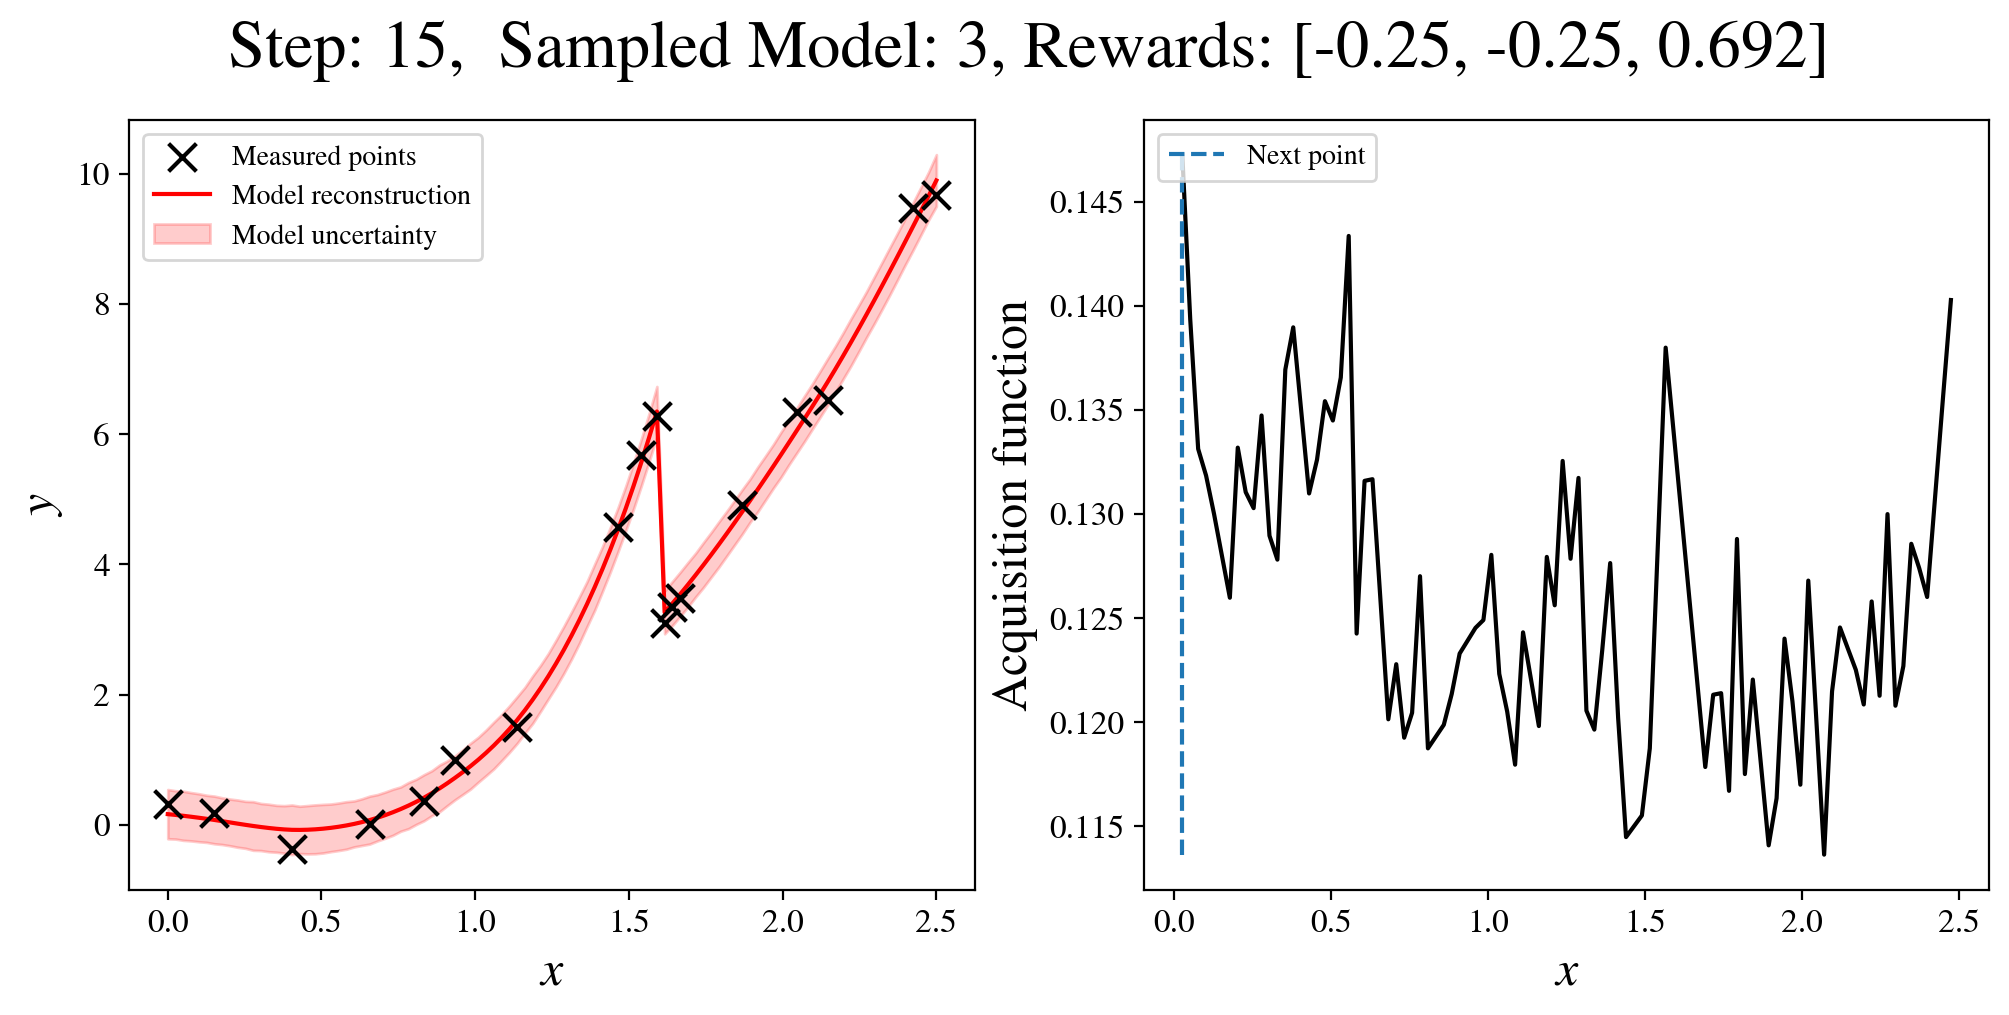

In [14]:
exploration_steps = 15
warmup_steps = 3
plot_reconstruction = True  # available only for exploration phase

# Create lists containing physical models and probabilistic priors over their parameters
models = [piecewise1, piecewise2, piecewise3]
model_priors = [piecewise1_priors, piecewise2_priors, piecewise3_priors]

onp.random.seed(1)  # rng seed for reproducibility

# Initialize the reward, predictive uncertainty and model selection records
record = onp.zeros((len(models), 2))
model_choices = []
obj_history = []

# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    obj_median_all, obj_all = [], []

    # Iterate over probabilistic models in the list
    for i, model in enumerate(models):

        # for each model, run BI and store uncertainty values
        obj, _ = gpax.hypo.step(
            model,
            model_priors[i],
            X_measured,
            y_measured,
            X_unmeasured,
            gp_wrap=True,
            gp_kernel='Matern',
            gp_kernel_prior=gp_kernel_prior,  # wrap model into a Gaussian process
            num_warmup=NUM_WARMUP,
            num_samples=NUM_SAMPLES,
        )
        record[i, 0] += 1
        obj_all.append(obj)

        # (one can use integral uncertainty instead of median)
        obj_median_all.append(jnp.nanmedian(obj).item())

    # Reward a model that has the smallest integral/median uncertainty
    idx = onp.argmin(obj_median_all)
    model_choices.append(idx)
    record[idx, 1] += 1

    # Store the integral/median uncertainty
    obj_history.append(obj_median_all[idx])

    # Compute the next measurement point using the predictive uncertainty of rewarded model
    obj = obj_all[idx]
    next_point_idx = obj.argmax()

    # Evaluate the function in the suggested point
    measured_point = function_(X_unmeasured[next_point_idx], params_i) + 0.2*onp.random.normal()

    # Update arrays with measured and unmeasured points
    X_measured, y_measured, X_unmeasured = update_datapoints(
        next_point_idx, measured_point, X_measured, y_measured, X_unmeasured
    )

# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Run exploration phase
for e in range(exploration_steps - warmup_steps):
    print("Exploration step {}/{}".format(e+warmup_steps+1, exploration_steps))

    # Choose model according to epsilon-greedy policy
    idx = gpax.hypo.sample_next(record[:, 1], method="eps-greedy", eps=0.4)
    model_choices.append(idx)
    print("Using model {}".format(idx+1))

    # Derive acquisition function with the selected model
    obj, m_post = gpax.hypo.step(
        models[idx],
        model_priors[idx],
        X_measured,
        y_measured,
        X_unmeasured,
        gp_wrap=True,
        gp_kernel='Matern',
        gp_kernel_prior=gp_kernel_prior,  # wrap the sampled model into a Gaussian process
        num_restarts=2,
        print_summary=False,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
    )

    # Get reward
    obj_history.append(jnp.nanmedian(obj).item())
    r = get_reward(obj_history)

    # Update records
    record = gpax.hypo.update_record(record, idx, r)

    # Get the next measurement point from the predictive uncertainty of the sampled model
    next_point_idx = obj.argmax()

    # Evaluate function in the suggested point
    measured_point = function_(X_unmeasured[next_point_idx], params_i) + 0.2*onp.random.normal()
    if plot_reconstruction:

        # plot current reconstruction and acqusition function
        y_pred, y_sampled = m_post.predict(gpax.utils.get_keys()[1], X)
        plot_results(
            X_measured,
            y_measured,
            X_unmeasured,
            y_pred,
            y_sampled.squeeze(),
            obj,
            idx+1,
            record[:, 1],
            e=e+warmup_steps
        )

    # Update arrays with measured and unmeasured points
    X_measured, y_measured, X_unmeasured = update_datapoints(
        next_point_idx,
        measured_point,
        X_measured,
        y_measured,
        X_unmeasured
    )

Plot integral/median uncerainty as a function of exploration steps:

(note that for the warm-up steps, we plot only model that produced lowest uncertainty)

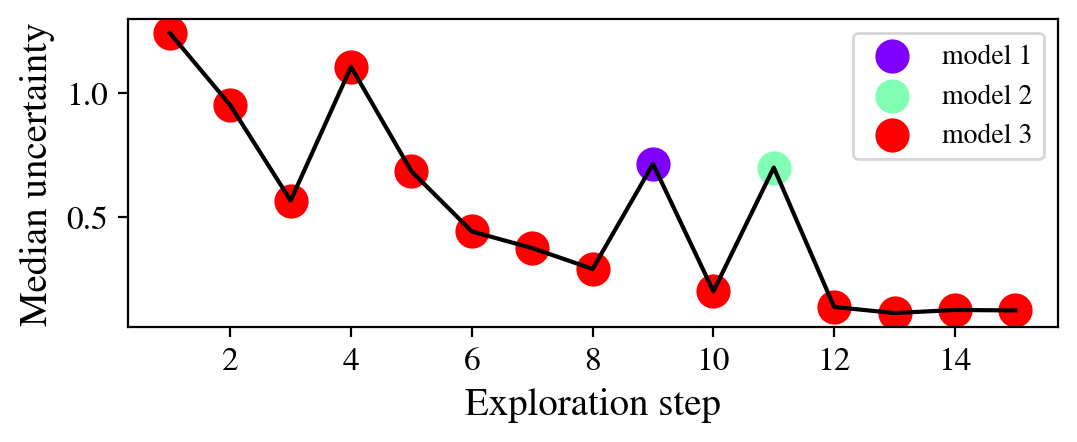

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
cmap = mpl.colormaps["rainbow"].resampled(3)
ax.plot(onp.arange(1, exploration_steps+1), obj_history, c='k')
for model_index in range(3):
    where = onp.where(onp.array(model_choices) == model_index)[0]
    ax.scatter(
        where + 1,
        onp.array(obj_history)[where],
        color=cmap(model_index),
        s=128,
        alpha=1,
        label=f"model {model_index+1}",
    )
ax.set_xlabel("Exploration step", fontsize=14)
ax.set_ylabel("Median uncertainty", fontsize=14)
ax.legend()
plt.show()

View average reward associated with each model:

(note that it counts the warmup steps where all the models were evaluated)

In [16]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), onp.round(r[1], 3)))

model 1:  counts 4  reward (avg) -0.25
model 2:  counts 4  reward (avg) -0.25
model 3:  counts 13  reward (avg) 0.692


Compute (and plot) each model's prediction over the entire grid using the final set of the discovered point:


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:49<00:00, 36.54it/s, 1023 steps of size 3.52e-03. acc. prob=0.76]



 Model 1, Reward (avg) -0.25


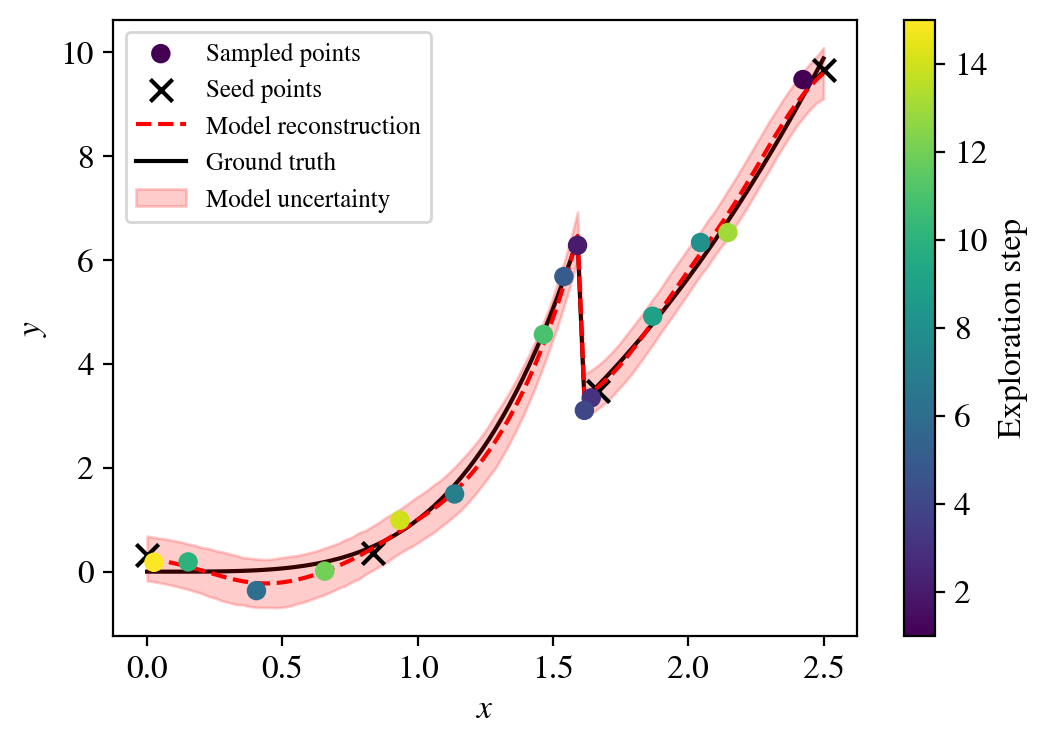

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:57<00:00, 34.17it/s, 1023 steps of size 3.14e-03. acc. prob=0.74]



 Model 2, Reward (avg) -0.25


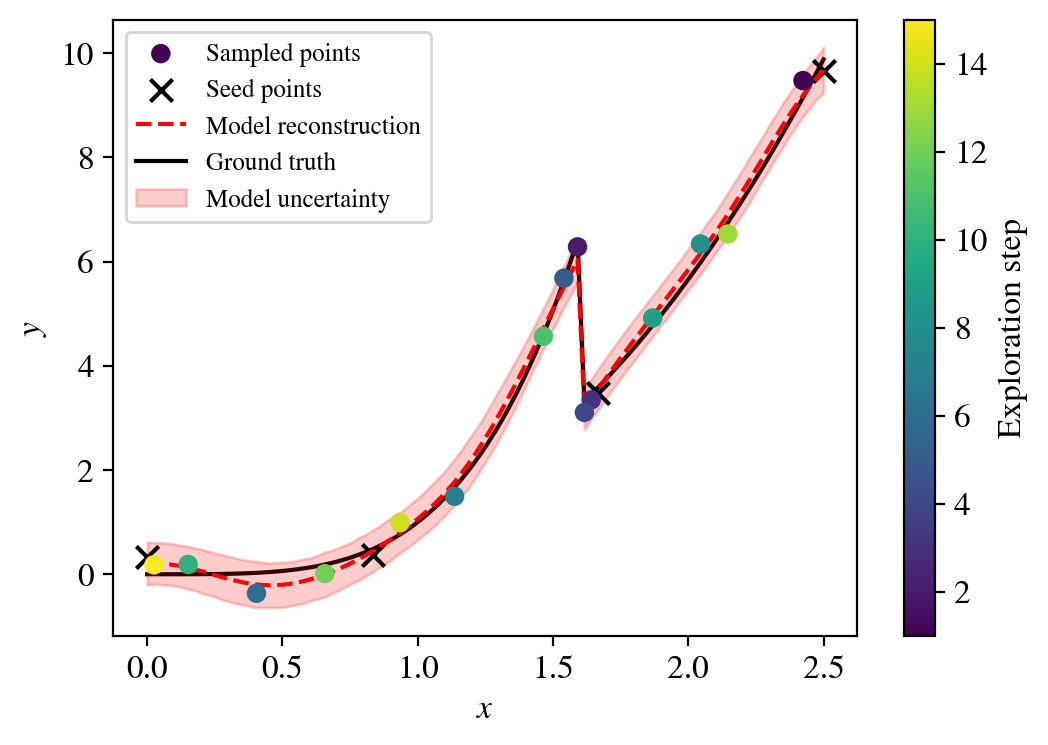

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:50<00:00, 36.05it/s, 1023 steps of size 3.44e-03. acc. prob=0.75]



 Model 3, Reward (avg) 0.692


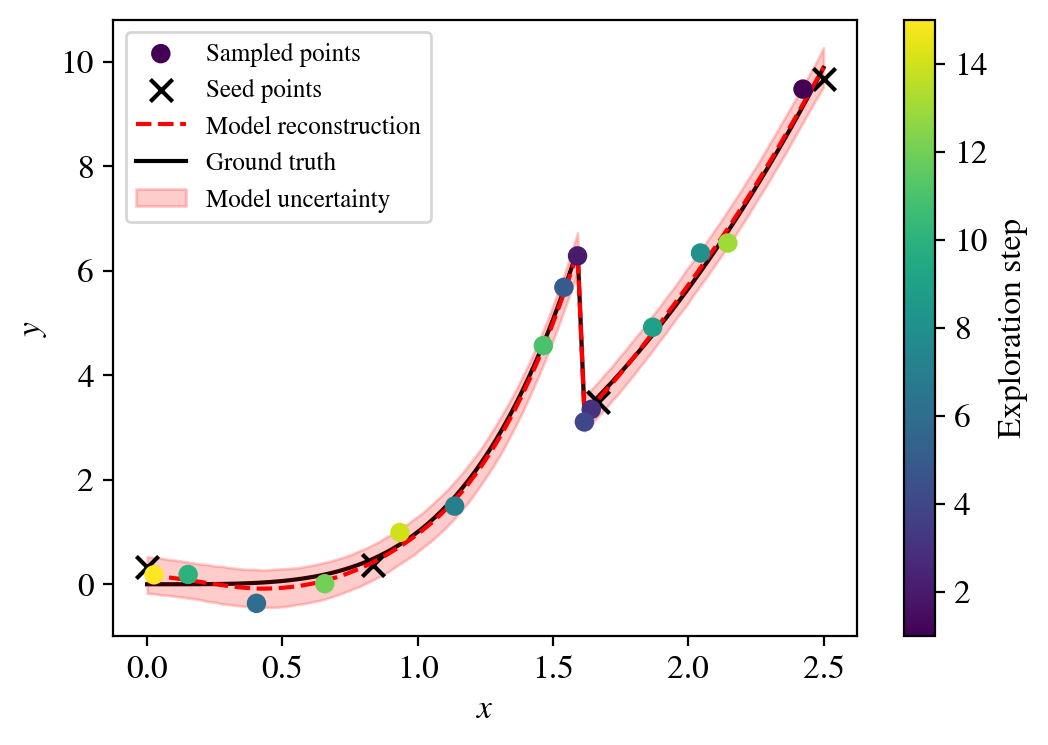

In [17]:
for i, model in enumerate(models):
    # use the same parameters as in the main loop
    _, gp_model = gpax.hypo.step(
        model,
        model_priors[i],
        X_measured,
        y_measured,
        gp_wrap=True,
        gp_kernel='Matern',
        gp_kernel_prior=gp_kernel_prior,
        num_restarts=2,
        print_summary=0,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
    )
    y_pred, y_sampled = gp_model.predict(gpax.utils.get_keys()[1], X)
    print("\n Model {}, Reward (avg) {}".format(i+1, onp.round(record[i, 1], 3)))
    plot_final_result(
        X_measured,
        y_measured,
        X, y_pred,
        y_sampled.squeeze(),
        seed_points=num_seed_points
    )

Note that because we wrapped our models in GP and because each model had a transition point, even the first two cases showed a satisfactory fit. At the same time, the model that received the highest reward (i.e. was
favored by our algorithm) provided the best fit accompanied by the smallest uncertainty. Hence, we were able to learn a distribution of property of interest with a small number of sparse measurements while also identifying a correct model describing the system’s behavior.